In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# These libraries allow interaction
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Allow viewing plots in jupyter
%matplotlib inline

## Check out the README for usage but quickly

* The requirements are in `requirements.txt` 
  * Install with `pip install -r requirements.txt`
* The dataset is [the two sigman connect rental](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data)
  * Install it with the [kaggle api](https://github.com/Kaggle/kaggle-api) 
  * `kaggle competitions download -c two-sigma-connect-rental-listing-inquiries` at the root of the project
  * `unzip two-sigma-connect-rental-listing-inquiries.zip`
  * `unzip train.json.zip`

In [135]:
df = pd.read_json('./train.json')

In [136]:
df.shape

(49352, 15)

In [137]:
df.head(1) # Quite a a verbose output

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium


In [138]:
df['interest_level'].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

In [139]:
df['price'].max(), df['price'].min() # 43 dollars!

(4490000, 43)

We begin by reading in the data, and reading some basic information about it.

We learn that the data: 
 * Has ~49,000 rows with 15 columns
   * 14 features, and the class `interest_level` that we must predict
 * The `interest_level` class has three possible values:
   * `low`, `medium`, and `high`
 * Maximum and minimum prices are 4.9 million dollars and 43 dollars respectively
   * As much as a broke student such as myself would love to believe in the 43 dollar listing, this is probably an error 

Let's visualize those target variables 👀 :

low       0.694683
medium    0.227529
high      0.077788
Name: interest_level, dtype: float64

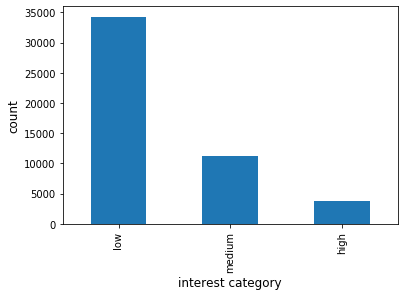

In [141]:
plt.ylabel('count', fontsize=12)
plt.xlabel('interest category', fontsize=12)
df['interest_level'].value_counts().plot(kind="bar");
df['interest_level'].value_counts(normalize=True)

We can see clearly there are many low-interest listings, and it slowly tapers off with very few high interest listings. Proportion percentages are shown on top.

We will now convert the data types in order to parse them correctly (such as dates)

In [142]:
df['created'] = pd.to_datetime(df['created'])

We can now do some analysis on the properties of this dataframe.

For example, we will plot the 

### Hour-wise listing counts: 

**Note** this is an _interactive_ function and will not render on github. Run the notebook locally instead. Use the dropdown to view the different types of plots.

In [143]:
hours = df['created'].groupby(
    df["created"].dt.hour
).count()

@interact
def show_hour_plot(kind=['line', 'bar']):
    plt.ylabel('count', fontsize=12)
    hours.plot(kind=kind);

interactive(children=(Dropdown(description='kind', options=('line', 'bar'), value='line'), Output()), _dom_cla…

In [144]:
hours.nlargest(5)

created
2    10596
3     8318
5     7954
1     5749
4     5021
Name: created, dtype: int64

As we can see, the top times are ~1am-7am. Perhaps people are updating then because there is less traffic. Or maybe scripts are running which update at that time. Or perhaps the postings are being made by employees outside of the New York timezone. 

Next, we observe the
### 💸 Price 💸

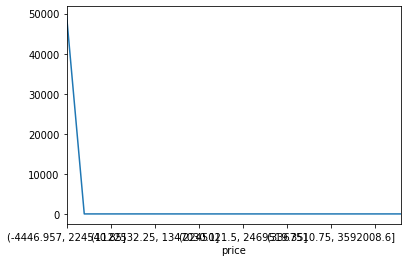

In [145]:
prices = df['price'].groupby(
    pd.cut(df['price'], 20)
).count() 

prices.plot();

We notice that the outliers are intrusive in this case and it would benefit us to remove them. To do this, we will remove the top percentile of some values.

In [146]:
@interact
def show_price_plot(
    kind=['line', 'bar', 'barh', 'area'],
    percentile_limit=(50, 100, 0.5),
    bins=(10,50,1),
):
    lim = np.percentile(df['price'].values, percentile_limit)
    lost_data = df[df['price']>lim].shape[0]

    adjusted_prices = df[df['price']<lim]['price']
    prices = adjusted_prices.groupby(
        pd.cut(adjusted_prices, bins)
    ).count() 
    
    xticks = [
        prices.index[i].right for i in range(0,len(prices))
    ]
    plt.ylabel('count', fontsize=12)
    prices.plot(
        kind=kind, grid=True
    ).set_xticklabels(xticks);

interactive(children=(Dropdown(description='kind', options=('line', 'bar', 'barh', 'area'), value='line'), Flo…

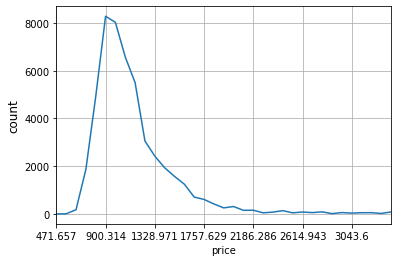

In [157]:
show_price_plot(kind='line', percentile_limit=99.5, bins=35)

Notice as we drag the percentiles higher (without hitting 100) the graph becomes more and more left-skewed. This shows us almost all the values are in the 2000-6000 dollar range. We find that 20 bins on the bar graph will achieve a good visualization.

Some might find the distribution histogram plot more engaging: 

In [148]:
@interact
def show_price_plot2(
    kind=['line', 'bar', 'barh', 'area'],
    percentile_limit=(50, 100, 0.5),
    bins=(10,50,1),
):
    lim = np.percentile(df['price'].values, percentile_limit)

    adjusted_prices = df[df['price']<lim]['price']
    
    sns.distplot(
        adjusted_prices.values, 
        bins=bins, 
        kde=True,
    )
    plt.ylabel('share', fontsize=12)
    plt.show()

interactive(children=(Dropdown(description='kind', options=('line', 'bar', 'barh', 'area'), value='line'), Flo…

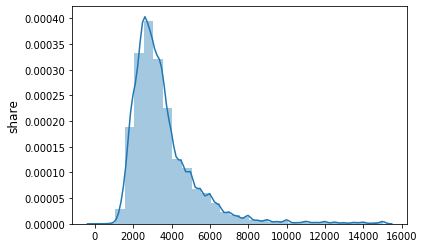

In [149]:
show_price_plot2(kind='line', percentile_limit=99.5, bins=30)

# Longitude and Lattitude

We will give these columns a similar treatment, allowing the choice between types of graph. Use the dropdowns for your options. We have provided the graphs as well for after for the pdf version of this report.

In [150]:
@interact
def show_long_plot1(
    axis=['longitude','latitude'],
    gtype=['sns','classic'],
    kind=['line', 'bar', 'barh', 'area'],
    upper_limit=(70, 100, 0.5),
    lower_limit=(0, 10, 0.5),
    bins=(10,50,1),
):
    lim = np.percentile(df[axis].values, upper_limit)
    low_lim = np.percentile(df[axis].values, lower_limit)
    
    adjusted = df[df[axis]<lim]
    adjusted = adjusted[adjusted[axis] > low_lim][axis]
    
    if(gtype == "sns"):
        sns.distplot(
            adjusted.values, 
            bins=bins, 
            kde=True,
        )
        plt.ylabel('count', fontsize=12)
        plt.show();
        
    elif(gtype == "classic"):
        prices = adjusted.groupby(
            pd.cut(adjusted, bins)
        ).count() 

        xticks = [
            prices.index[i].right for i in range(0,len(prices))
        ]
        plt.ylabel('share', fontsize=12)
        prices.plot(
            kind=kind, grid=True
        ).set_xticklabels(xticks);
        


interactive(children=(Dropdown(description='axis', options=('longitude', 'latitude'), value='longitude'), Drop…

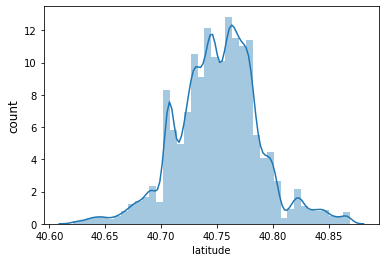

In [151]:
plot = 'latitude'
plt.xlabel(plot)
show_long_plot1(plot,'sns','bar',99.5,0.5,40)

Notice that the values are mostly in the 40-41 range

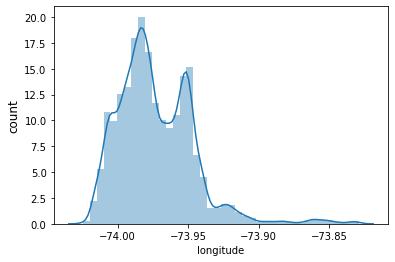

In [152]:
plot = 'longitude'
plt.xlabel(plot)
show_long_plot1(plot,'sns','bar',99.5,0.3,40)

# Conclusion of latitude and longitude

The values are in the -73 to -74 range, and the 40-41 range.

After [some searching](https://www.latlong.net/place/new-york-city-ny-usa-1848.html) we realize these values belong to New York City.

Also of note when playing with the interactive plots we created, we realized that the graph varies drastically when the percentile of included data reaches 100 compared to 99.6. This gives us insight into the fact of the amount of outliers within this dataset. We analyze these outliers more later in this report but in essence after viewing the graph skew, we've decided to remove the top 0.3% off the top and 0.2% off the bottom. This loses less than 1 percent of the data but perserves the essence of the graph (i.e. the same general shape of the graph it would look like with, say 25% off the top and bottom).

We highly encourage readers of this document to use the interactive plots by cloning the [repo](https://github.com/SinaKhalili/kaggle-data-analysis) and running the notebook locally.

This concludes our data exploration phase, though we did look at other things in the dataset such bedroom distribution and other numerical attributes.

## Outliers

We now analyze the outliers more thoroughly. We provide a function to view the number of data points lying outside a certain range of percentile. Again, these numbers were decided by viewing the graphs.

The graphs are then provided after the numbers.

In [20]:
def get_num_outliers(o_axis):
    o_upper_limit = 99.95
    o_lower_limit = 0.03
    o_lim = np.percentile(df[o_axis].values, o_upper_limit)
    o_low_lim = np.percentile(df[o_axis].values, o_lower_limit)
    o_loss = df[df[o_axis] > o_lim][o_axis].count()
    o_loss_2 = df[df[o_axis] < o_low_lim][o_axis].count()
    return o_loss + o_loss_2

In [132]:
outlier_aggregate = {}
#Take out bedroom and bathrooms because we do not consider them to be outliers.
for cat in ['latitude', 'longitude','price']:
    print(f"Number of outliers is {get_num_outliers(cat)} in {cat}")
    outlier_aggregate[cat] = get_num_outliers(cat)

Number of outliers is 40 in latitude
Number of outliers is 40 in longitude
Number of outliers is 40 in price


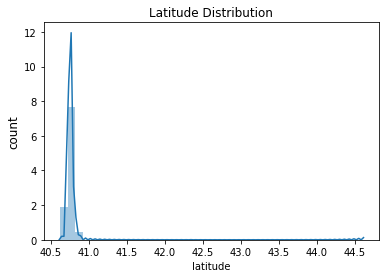

In [116]:
plot = 'latitude'
plt.xlabel(plot)
plt.title("Latitude Distribution")
show_long_plot1(plot,'sns','bar',100,0.5,40)

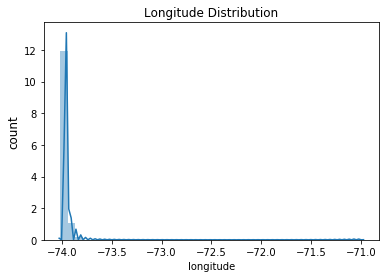

In [160]:
plot = 'longitude'
plt.xlabel(plot)
plt.title("Longitude Distribution")
show_long_plot1(plot,'sns','bar',100,0.5,40)

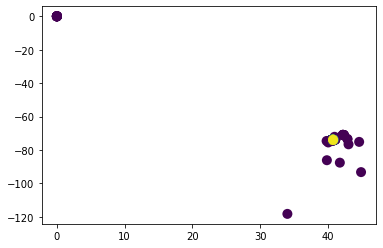

In [161]:
from scipy.stats import gaussian_kde
x = df["latitude"]
y = df["longitude"]


xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
plt.show()

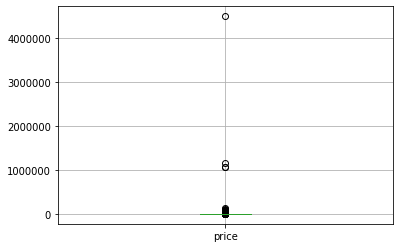

In [129]:
PriceBoxWOOL = df.boxplot(column = ['price'], showfliers = True); PriceBoxWOOL;

Outliers heavily affect the graph when comparing the price column's boxplots.

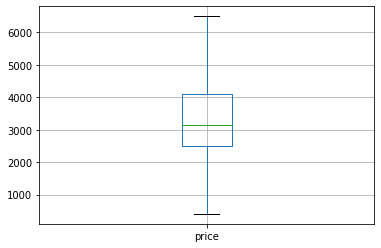

In [159]:
PriceBoxWOOL2 = df.boxplot(column = ['price'], showfliers = False); PriceBoxWOOL2;

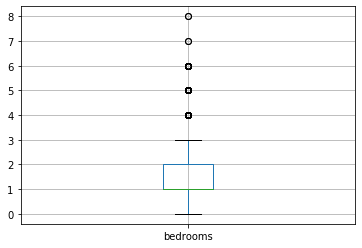

In [24]:
BedBox = df.boxplot(column = ['bedrooms'], showfliers = True); BedBox;

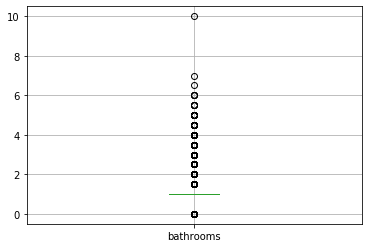

In [26]:
BathBoxWOOL = df.boxplot(column = ['bathrooms'], showfliers = True); BathBoxWOOL;

In [133]:
outlierAggregate = pd.DataFrame(outlier_aggregate,index=['Number of Outliers'])
outlierAggregate

,latitude,longitude,price
Number of Outliers,40,40,40


## Outlier Analysis 

For most of the attributes, doing outlier analysis is not beneficial. Attributes that have non-numerical datatypes, such as `created`, `description`, `display_address`, `features`, `photos`, `street_address`, `interest_level` do not have a metric to clearly define an outlier with, therefore it does not make sense to include them for our analysis. 

Attributes with id fields, `building_id`, `listing_id`, `manager_id`, cannot be evaluated as outliers because those fields are deterministically calculated by way of a hashing algorithm.

For `bedrooms` and `bathrooms`, we decided against counting these values as outliers. `0-7` and `0-10` for `bedrooms` and `bathrooms` respectively was such a tight range of integer values that we had to be conservative about what we considered as an outlier. We considered the rental listing that had 10 bathrooms as an outlier, but with such a small range of possible values, we decided it was not extreme enough to remove the tuple.

For `latitude` and `longitude`, we will remove the outliers. Namely, those in the bottom 0.2% and the top 0.3%, which make up for less than 1.0% of the graph. For the histogram above, removal of the outliers makes the graph more readable without compromising the bulk of the data.

For `price`, after looking at its boxplot and histogram above, it is evident that we will remove the outliers. Its range of values is too spread out such that outliers heavily skew the graphs. We will consider all prices greater than `one million` to be outliers because these do not make the 99.5th percentile.


# Missing values


In [58]:
#applies a function along an axis in the dataframe. 
#axis = 0 are rows, axis = 1 are columns
missing_values = {}
for cat in df.columns:
    missing_values[cat] = df[
        df.apply(lambda x: x[cat]== '' or x[cat] == '0' or x[cat] == 0 or x[cat] == 0.0, axis = 1)
    ][cat].count()

missing_values['bathrooms'] = df[ df.apply(lambda x: x['bathrooms']== '',axis = 1) ] ['bathrooms'].count()
missing_values['bedrooms'] = df[ df.apply(lambda x: x['bedrooms']== '',axis = 1) ] ['bedrooms'].count()

missing_values

{'bathrooms': 0,
 'bedrooms': 0,
 'building_id': 8286,
 'created': 0,
 'description': 1446,
 'display_address': 135,
 'features': 0,
 'latitude': 12,
 'listing_id': 0,
 'longitude': 12,
 'manager_id': 0,
 'photos': 0,
 'price': 0,
 'street_address': 10,
 'interest_level': 0}

In [59]:
missingValues = pd.DataFrame(missing_values,index=['Number of Missing Values'])
missingValues

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
Number of Missing Values,0,0,8286,0,1446,135,0,12,0,12,0,0,0,10,0


## Discussion and plan to deal with the missing values
 * We have chosen not to interpret the number `0` as a missing value for the `bedroom` and `bathroom` categories, as it is entirely possible to have a listing with `0` as a value. For instance, no bedroom, but you sleep on the couch.
 * For the rest of the columns we look to see if it falls into a few cases of malformed or missing datum. We noticed there were no explicit `None` values.
 * Also of note is the `building_id` is the most frequently missing value, however this is inconsequential to our analysis, as it contains no relevant information for this analysis. We can safely drop this whole column, so the missing values don't impact this decision.
 * Regarding `description`, we will deal with the missing values by averaging the values from the feature extraction. Compared to the number of total entries, it is a relatively miniscule amount of entries but the text data that it provides is useful for our text data feature extraction, so we will keep them.
 * The `display_address` *could also be derived from the `street_address`* (simply by removing the unit number). 
 * The `latitude` and `longitude` *could be derived from the address*, given that it exists. In the case that **both** the address and the longitude-latitude do not exist, we can safely drop the row, as the number of such cases make up less than 0.01 percent of the dataset, an inconsequential number. 
 * In the case that the `street_address` is also missing, we will eliminate the row. These cases also align with the cases described above and in the end will lose again less than 0.01 percent of the data, which we consider an inconsequential sum.
 